# State Estimation in Linear Gaussian SSM with Composite Nodes

We consider the generative model

\begin{align*}
    u_t &\sim \mathcal{N}(0, w_s^{-1})\\
    v_t &\sim \mathcal{N}(0, w_x^{-1})\\
    s_t &= a \cdot s_{t-1} + u_t\\
    x_t &= c \cdot s_t + v_t
\end{align*}

# Generate Data

In [1]:
# General settings
T = 50
w_s_data = 100.0 # State evolution precision 
w_x_data = 10.0 # Observation precision
a_data = 1.0
c_data = 1.0

# Generate some data
s_data = Vector{Float64}(T) # States
x_data = Vector{Float64}(T) # Observations

s_data_0 = 0.0
s_data_t_min = s_data_0
for t = 1:T
    u_t = sqrt(1/w_s_data)*randn()
    v_t = sqrt(1/w_x_data)*randn()
    s_data[t] = a_data*s_data_t_min + u_t
    x_data[t] = c_data*s_data[t] + v_t

    # Preprare next state
    s_data_t_min = s_data[t]
end

# Build

In [2]:
using ForneyLab

# Declare new node
@composite GainAddition (out, gain, in1, in2) begin
   out = gain*in1 + in2 
end

In [3]:
# Start a new graph
g = FactorGraph()

# Initial state prior
s_0 ~ GaussianMeanVariance(constant(0.0), constant(100.0), id=:s_0)

# Build generative model
x = Vector{Variable}(T)
s = Vector{Variable}(T)
s_t_min = s_0
for t = 1:T
    u_t ~ GaussianMeanPrecision(constant(0.0), constant(w_s_data), id=:u_*t) # Transition noise
    v_t ~ GaussianMeanPrecision(constant(0.0), constant(w_x_data), id=:v_*t) # Observation noise
    s[t] = Variable(id=:s_*t) # Note: with custom nodes, the ~ notation won't work; therefore we must be explicit
    x[t] = Variable(id=:x_*t)
    GainAddition(s[t], constant(a_data), s_t_min, u_t) # State transition model
    GainAddition(x[t], constant(c_data), s[t], v_t) # Observation model
    
    placeholder(x[t], :x, index=t) # Placeholder for data

    # Preprare next state
    s_t_min = s[t]
end
;

# Schedule

In [4]:
# Define custom rules for GainAddition node
@sumProductRule(:node_type     => GainAddition,
                :outbound_type => Message{Gaussian},
                :inbound_types => (Void, Message{PointMass}, Message{Gaussian}, Message{Gaussian}),
                :name          => SPGainAdditionOutVPGG)

@sumProductRule(:node_type     => GainAddition,
                :outbound_type => Message{Gaussian},
                :inbound_types => (Message{PointMass}, Message{PointMass}, Void, Message{Gaussian}),
                :name          => SPGainAdditionIn1PPVG)

@sumProductRule(:node_type     => GainAddition,
                :outbound_type => Message{Gaussian},
                :inbound_types => (Message{Gaussian}, Message{PointMass}, Void, Message{Gaussian}),
                :name          => SPGainAdditionIn1GPVG)

@sumProductRule(:node_type     => GainAddition,
                :outbound_type => Message{Gaussian},
                :inbound_types => (Message{Gaussian}, Message{PointMass}, Message{Gaussian}, Void),
                :name          => SPGainAdditionIn2GPGV)
;

In [5]:
# Generate a sum-product schedule and compile to Julia code
algo_s = sumProductAlgorithm([s_0; s], name="S")

# Inspect algorithm code
# Note: previously there were 499 messages
println(algo_s)

# Parse and load algorithm code in scope
eval(parse(algo_s))
;

function stepS!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(349))

messages[1] = ruleSPGaussianMeanVarianceOutVPP(nothing, Message(Univariate, PointMass, m=0.0), Message(Univariate, PointMass, m=100.0))
messages[2] = ruleSPGaussianMeanPrecisionOutVPP(nothing, Message(Univariate, PointMass, m=0.0), Message(Univariate, PointMass, m=10.0))
messages[3] = ruleSPGainAdditionIn1PPVG(Message(Univariate, PointMass, m=data[:x][1]), Message(Univariate, PointMass, m=1.0), nothing, messages[2])
messages[4] = ruleSPGaussianMeanPrecisionOutVPP(nothing, Message(Univariate, PointMass, m=0.0), Message(Univariate, PointMass, m=10.0))
messages[5] = ruleSPGainAdditionIn1PPVG(Message(Univariate, PointMass, m=data[:x][2]), Message(Univariate, PointMass, m=1.0), nothing, messages[4])
messages[6] = ruleSPGaussianMeanPrecisionOutVPP(nothing, Message(Univariate, PointMass, m=0.0), Message(Univariate, PointMass, m=10.0))
messages[7] = ruleSPGainAdditionIn1PPVG(Message(Univariate, 

# Infer

In [6]:
# Define Julia implementation of custom updates for GainAddition node
function ruleSPGainAdditionOutVPGG(msg_out::Void,
                                   msg_gain::Message{PointMass},
                                   msg_in1::Message{Gaussian},
                                   msg_in2::Message{Gaussian})

    ForneyLab.ensureParameters!(msg_in1.dist, (:m, :v))
    ForneyLab.ensureParameters!(msg_in2.dist, (:m, :v))

    A = msg_gain.dist.params[:m]
    Message(Gaussian, m = A*msg_in1.dist.params[:m] + msg_in2.dist.params[:m],
                      v = A*msg_in1.dist.params[:v]*A' + msg_in2.dist.params[:v])
end

ruleSPGainAdditionIn2GPGV(msg_out::Message{Gaussian},
                          msg_gain::Message{PointMass},
                          msg_in1::Message{Gaussian},
                          msg_in2::Void) =
    ruleSPGainAdditionOutVPGG(nothing, msg_gain, msg_in1, msg_out)

function ruleSPGainAdditionIn1GPVG(msg_out::Message{Gaussian},
                                   msg_gain::Message{PointMass},
                                   msg_in1::Void,
                                   msg_in2::Message{Gaussian})

    ForneyLab.ensureParameters!(msg_out.dist, (:m, :v))
    ForneyLab.ensureParameters!(msg_in2.dist, (:m, :v))

    A_inv = pinv(msg_gain.dist.params[:m])
    Message(Gaussian, m = A_inv*(msg_out.dist.params[:m] - msg_in2.dist.params[:m]),
                      v = A_inv*(msg_out.dist.params[:v] + msg_in2.dist.params[:v])*A_inv')
end

function ruleSPGainAdditionIn1PPVG(msg_out::Message{PointMass},
                                   msg_gain::Message{PointMass},
                                   msg_in1::Void,
                                   msg_in2::Message{Gaussian})

    ForneyLab.ensureParameters!(msg_in2.dist, (:m, :v))

    A_inv = pinv(msg_gain.dist.params[:m])
    Message(Gaussian, m = A_inv*(msg_out.dist.params[:m] - msg_in2.dist.params[:m]),
                      v = A_inv*msg_in2.dist.params[:v]*A_inv')
end
;

In [7]:
# Prepare data dictionary
data = Dict(:x => x_data)

# Run the algorithm on the data
marginals = stepS!(data)
;

# Results

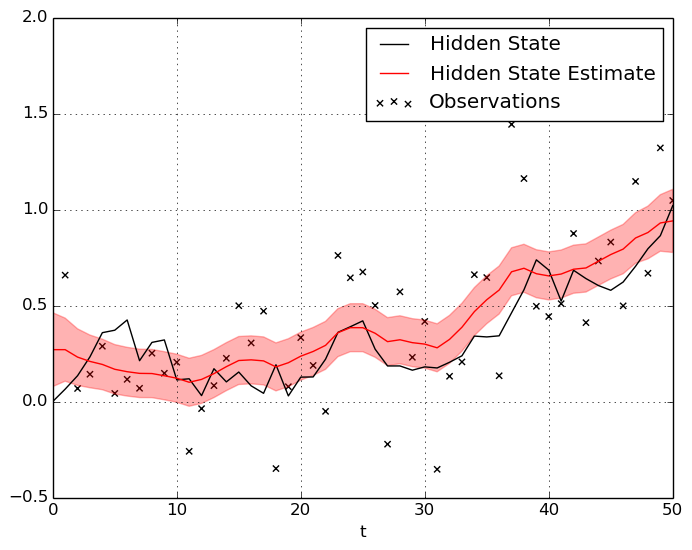

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


In [8]:
using PyPlot

# Visualize the results
m_s_est = [mean(marginals[:s_*t]) for t=0:T]
v_s_est = [var(marginals[:s_*t]) for t=0:T]

# Plot hidden state (estimate) and observations
plot(0:T, [s_data_0; s_data], color="black", label="Hidden State")
scatter(1:T, x_data, marker="x", color="black", label="Observations")
plot(0:T, m_s_est, color="red", label="Hidden State Estimate")
fill_between(0:T, m_s_est - sqrt(v_s_est), m_s_est + sqrt(v_s_est), color="red", alpha=0.3)
xlim(0, T)
grid("on")
xlabel("t")
legend()
;